In [1]:
import pyLDAvis.gensim
import pyLDAvis
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import csv
from scipy.spatial import distance
import collections
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn
import numpy as np
import swifter  # Makes applying to datframe as fast as vectorizing
from gensim import models  # For TF-IDF, LDA
import gensim
from nltk.probability import FreqDist
import string
from nltk.corpus import stopwords
import glob
import os
import pandas as pd
import re
from pandas import Series, DataFrame
from textblob import TextBlob, Word
import nltk
from nltk.util import ngrams
import re
nltk.download('stopwords')

# Visualization
plt.style.use('dark_background')
%matplotlib inline

# LDA Visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
unable to import 'smart_open.gcs', disabling that module


In [3]:
stop_words = stopwords.words('english')
f = open('/Users/shreya/nih_stopwords.txt', 'r')
stop_words.extend([word.rstrip('\n') for word in f])
f.close()
stop_words.extend(['a', 'in', 'of', 'the', 'at', 'on', 'and', 'with', 'from', 'to', 'for',
                   'some', 'but', 'not', 'their', 'human', 'mouse', 'rat', 'monkey', 'man',
                   'method', 'during', 'process', 'hitherto', 'unknown', 'many', 'these',
                   'have', 'into', 'improved', 'use', 'find', 'show', 'may', 'study', 'result',
                   'contain', 'day', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
                   'nine', 'ten', 'give', 'also', 'suggest', 'data', 'number', 'right reserved',
                   'right', 'reserve', 'society', 'american', 'publish', 'group', 'wiley', 'depend',
                   'upon', 'good', 'within', 'small', 'amount', 'large', 'quantity', 'control',
                   'complete', 'record', 'task', 'effect', 'single', 'database', 'ref',
                   'ref', 'university', 'press', 'psycinfo', 'apa', 'inc', 'alan', 'find', 'finding',
                   'perform', 'new', 'reference', 'noticeable', 'america', 'copyright', 'attempt', 'make',
                   'theory', 'demonstrate', 'present', 'analysis', 'other', 'due', 'receive', 'rabbit',
                   'property', 'e.g.', 'and/or', 'or', 'unlikely', 'nih', 'cause', 'best', 'well',
                   'without', 'whereas', 'whatever', 'require', 'wiley', 'aaa', 'whether', 'require',
                   'relevant', 'take', 'together'])  # ---> updated based on results


def preprocess_text(doc, n_grams='two'):
    """
    Pre-processing using TextBlob: 
    tokenizing, converting to lower-case, and lemmatization based on POS tagging, 
    removing stop-words, and retaining tokens greater than length 2

    We can also choose to include n_grams (n = 1,2,3) in the final output

    Argument(s): 'doc' - a string of words or sentences.
                 'n_grams' - one: only unigrams (tokens consisting of one word each)
                           - two: only bigrams
                           - two_plus: unigrams + bigrams
                           - three: only trigrams 
                           - three_plus: unigrams + bigrams + trigrams

    Output: 'reuslt_singles' - a list of pre-processed tokens (individual words) of each sentence in 'doc'
            'result_ngrams' - a list of pre-processed tokens (including n-grams) of each sentence in 'doc'

    """

    blob = TextBlob(doc).lower()
#     lang = blob.detect_language()
#     print(lang)
#     if lang != 'en':
#         blob = blob.translate(to = 'en')

    result_singles = []

    tag_dict = {"J": 'a',  # Adjective
                "N": 'n',  # Noun
                "V": 'v',  # Verb
                "R": 'r'}  # Adverb

    # For all other types of parts of speech (including those not classified at all)
    # the tag_dict object maps to 'None'
    # the method w.lemmatize() defaults to 'Noun' as POS for those classified as 'None'

    for sent in blob.sentences:

        words_and_tags = [(w, tag_dict.get(pos[0])) for w, pos in sent.tags]
        lemmatized_list = [w.lemmatize(tag) for w, tag in words_and_tags]

        for i in range(len(lemmatized_list)):

            if lemmatized_list[i] not in stop_words and len(lemmatized_list[i].lower()) > 2 and not lemmatized_list[i].isdigit():
                result_singles.append(lemmatized_list[i].lower())

    result_bigrams = ['_'.join(x) for x in ngrams(result_singles, 2)]

    result_bigrams = [
        token for token in result_bigrams if token != 'psychological_association']

    result_trigrams = ['_'.join(x) for x in ngrams(result_singles, 3)]
    result_two_plus = result_singles + result_bigrams
    result_three_plus = result_singles + result_bigrams + result_trigrams

    if n_grams == 'one':
        result = result_singles
    elif n_grams == 'two':
        result = result_bigrams
    elif n_grams == 'three':
        result = result_trigrams
    elif n_grams == 'two_plus':
        result = result_two_plus
    elif n_grams == 'three_plus':
        result = result_three_plus

    return result

In [4]:
def get_frequency(processed_text_list):
    """
    Using a built-in NLTK function that generates tuples
    We get the frequency distribution of all words/n-grams in a tokenized list
    We can get the proportion of the the token as a fraction of the total corpus size  ----> N/A
    We can also sort these frequencies and proportions in descending order in a dictionary object ----> N/A

    Argument(s): 'processed_text_list' - A list of pre-processed tokens

    Output(s): freq_dict - A dictionary of tokens and their respective frequencies in descending order
    """
    # prop_dict - A dictionary of tokens and their respective proportions as a fraction of the total corpus
    # combined_dict - A dictionary whose values are both frequencies and proportions combined within a list
    # """

    word_frequency = FreqDist(word for word in processed_text_list)

#     sorted_counts = sorted(word_frequency.items(), key = lambda x: x[1], reverse = True)
#     freq_dict = dict(sorted_counts)
    freq_dict = dict(word_frequency)
#     prop_dict = {key : freq_dict[key] * 1.0 / sum(freq_dict.values()) for key, value in freq_dict.items()}
#     combined_dict = {key : [freq_dict[key], freq_dict[key] * 1.0 / sum(freq_dict.values())] for key, value in freq_dict.items()}

    return freq_dict  # , prop_dict, combined_dict

In [5]:
def merge_vocab_dictionary(vocab_column):
    """
    Takes any number of token frequency dictionaries and merges them while summing 
    the respective frequencies and then calculates the proportion of the the tokens 
    as a fraction of the total corpus size and saves to text and CSV files


    Argument(s): vocab_column - A column of dictionary objects

    Output(s): merged_combined_dict - A list object containing the frequencies of all
               merged dictionary tokens along with their respective proportions
    """

    merged_freq_dict = {}
    for dictionary in vocab_column:
        for key, value in dictionary.items():  # d.items() in Python 3+
            merged_freq_dict.setdefault(key, []).append(1)

    for key, value in merged_freq_dict.items():
        merged_freq_dict[key] = sum(value)

    sorted_merged_freq_dict = sorted(
        merged_freq_dict.items(), key=lambda x: x[1], reverse=True)

#     total_sum = sum(merged_freq_dict.values())
#     merged_prop_dict = {key : merged_freq_dict[key] * 1.0 / total_sum for key, value in merged_freq_dict.items()}
#     merged_combined_dict = {key : [merged_freq_dict[key], (merged_freq_dict[key] * 1.0 / total_sum)] for key, value in merged_freq_dict.items()}

    return sorted_merged_freq_dict

In [51]:
mcl_data = pd.read_csv(
    "/Users/shreya/Desktop/Theta_plus/MCL_ncf_abstract_top10_csv/ncf_20_top10_1_title_abstract.csv")

In [53]:
mcl_data.head()

,scp,title,abstract_text
0,14949207,Cleavage of structural proteins during the ass...,Using an improved method of gel electrophoresi...
1,84981840703,An Eight‐day Method for Screening Compounds ag...,SYNOPSIS. Intracardial inoculation of 1–10 mil...
2,17184389,A rapid and sensitive method for the quantitat...,A protein determination method which involves ...
3,23922515,Identification of the avian homologues of mamm...,Two mAb were produced against chicken T cells....
4,33751553722,Nitrogen to Protein Conversion Factor for Ten ...,The main two kinds of usual nitrogen to protei...


In [8]:
data_text = mcl_data.copy()
data_text['scp'] = data_text.astype('str')
data_text['processed_title'] = data_text['title'].swifter.apply(
    preprocess_text)
data_text['processed_abstract'] = data_text['abstract_text'].swifter.apply(
    preprocess_text)

data_text['processed_all_text'] = data_text['processed_title'] + data_text['processed_abstract']

/Users/shreya/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
data_text['processed_all_text_frequencies'] = data_text['processed_all_text'].swifter.apply(
    get_frequency)

In [10]:
data_text.head()

,scp,title,abstract_text,processed_title,processed_abstract,processed_all_text,processed_all_text_frequencies
0,14094190,THE HIPPOCAMPUS AND BEHAVIOR,THE LITERATURE ON THE BEHAVIORAL EFFECTS OF HI...,[hippocampus_behavior],"[literature_behavioral, behavioral_hippocampal...","[hippocampus_behavior, literature_behavioral, ...","{'hippocampus_behavior': 1, 'literature_behavi..."
1,15027475,Limbic-diencephalic mechanisms of voluntary mo...,Data from a series of brain-behavior experimen...,"[limbic-diencephalic_mechanism, mechanism_volu...","[series_brain-behavior, brain-behavior_experim...","[limbic-diencephalic_mechanism, mechanism_volu...","{'limbic-diencephalic_mechanism': 1, 'mechanis..."
2,16308045,Recognition impaired and association intact in...,Three rhesus monkeys with transection of the f...,"[recognition_impair, impair_association, assoc...","[rhesus_transection, transection_fornix, forni...","[recognition_impair, impair_association, assoc...","{'recognition_impair': 1, 'impair_association'..."
3,15699567,The hippocampus and behavioral maturation,The morphology and connections of the hippocam...,"[hippocampus_behavioral, behavioral_maturation]","[morphology_connection, connection_hippocampus...","[hippocampus_behavioral, behavioral_maturation...","{'hippocampus_behavioral': 1, 'behavioral_matu..."
4,16770743,Latent inhibition and stimulus generalization ...,30 male and female New Zealand albino rabbits ...,"[latent_inhibition, inhibition_stimulus, stimu...","[male_female, female_zealand, zealand_albino, ...","[latent_inhibition, inhibition_stimulus, stimu...","{'latent_inhibition': 2, 'inhibition_stimulus'..."


In [11]:
data_all_text_frequency = merge_vocab_dictionary(
    data_text['processed_all_text_frequencies'])

In [12]:
# title_all_text_frequency[:50]

Total number of articles:  171


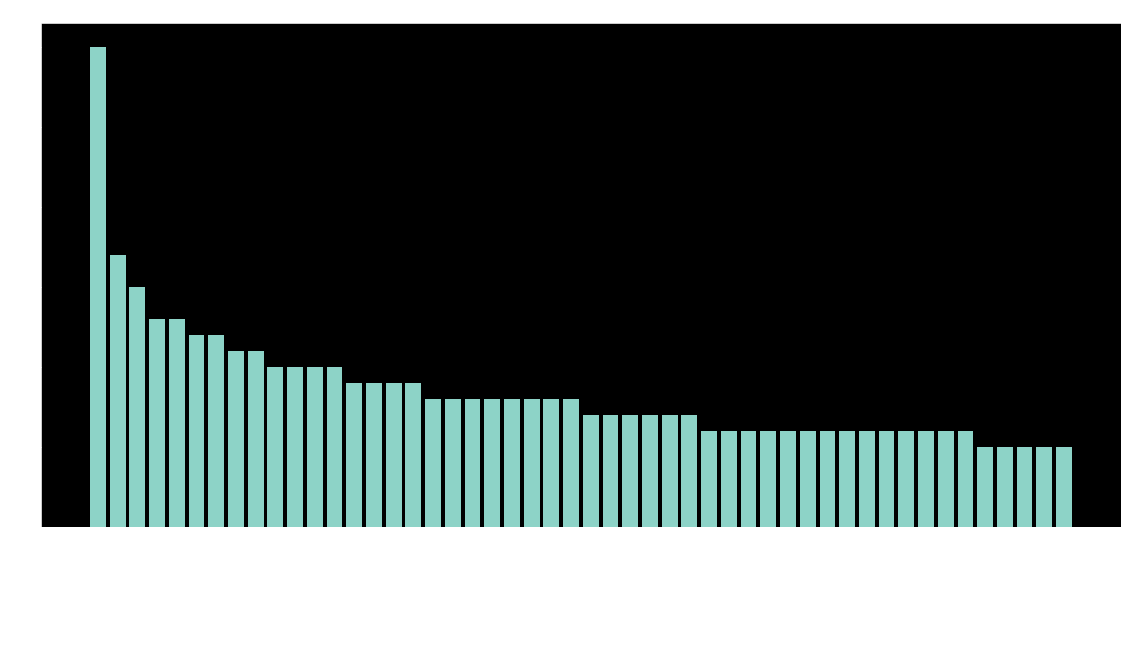

In [14]:
print('Total number of articles: ', len(data_text))

max_freq_tokens = [i[0] for i in data_all_text_frequency[:50]]
max_freq_token_counts = [i[1] for i in data_all_text_frequency[:50]]
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(max_freq_tokens, max_freq_token_counts)
plt.title('Top 50 Most Frequent Tokens in ncf_20_1_title')
plt.ylabel('Frequncy')
plt.xticks(rotation=90)
plt.show()

In [15]:
# def make_bow(doc):

#     bow_corpus = id2word_n_1.doc2bow(doc)

#     return bow_corpus

In [16]:
# Create Dictionary
mcl_dictionary = gensim.corpora.Dictionary(
    data_text.processed_all_text.tolist())

# Create Corpus
mcl_all_text = data_text.processed_all_text.tolist()

mcl_corpus = [' '.join(text) for text in mcl_all_text]

# Term Document Frequency
mcl_bow_corpus = [mcl_dictionary.doc2bow(text) for text in mcl_all_text]

In [17]:
num_topics = 1

# Build LDA model
mcl_lda = gensim.models.ldamodel.LdaModel(corpus=mcl_bow_corpus,
                                          id2word=mcl_dictionary,
                                          num_topics=num_topics,
                                          random_state=100,
                                          update_every=1,
                                          chunksize=100,
                                          passes=10,
                                          alpha='auto',
                                          per_word_topics=True)

In [18]:
print(mcl_lda.print_topics(num_words=50))

[(0, '0.002*"hippocampal_lesion" + 0.001*"hippocampal_formation" + 0.001*"work_memory" + 0.001*"spatial_learning" + 0.001*"amnesic_patient" + 0.001*"spatial_memory" + 0.001*"temporal_lobe" + 0.001*"pyramidal_cell" + 0.001*"place_cell" + 0.001*"granule_cell" + 0.001*"short-term_memory" + 0.001*"water_maze" + 0.001*"medial_temporal" + 0.001*"perforant_path" + 0.001*"lesion_produce" + 0.001*"correct_response" + 0.001*"hippocampal_place" + 0.001*"memory_function" + 0.001*"membrane_response" + 0.001*"nictitate_membrane" + 0.000*"memory_impairment" + 0.000*"hippocampal_function" + 0.000*"classical_conditioning" + 0.000*"spatial_information" + 0.000*"dorsal_hippocampus" + 0.000*"prefrontal_cortex" + 0.000*"entorhinal_cortex" + 0.000*"damage_hippocampus" + 0.000*"discrimination_learning" + 0.000*"memory_deficit" + 0.000*"learning_memory" + 0.000*"mec_cell" + 0.000*"temporal_lobectomy" + 0.000*"fimbria-fornix_lesion" + 0.000*"long-term_memory" + 0.000*"discuss_term" + 0.000*"bilateral_hippocamp

In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(mcl_lda, mcl_bow_corpus, mcl_dictionary)
# vis

In [20]:
def get_lda_tokens(lda_model=mcl_lda, num_tokens=30):
    """
    In current state, only works for num_topics = 1
    """

    x = lda_model.show_topics(num_words=num_tokens, formatted=False)

    topic_tokens = []
    for topics in x:
        for word, prob in topics[1]:
            topic_tokens.append(word)

    return topic_tokens

In [21]:
# Cosine Similarities
def token_to_doc_similarity(doc, compare='lda', num_tokens=30):

    if compare == 'lda':
        compare_tokens = get_lda_tokens(mcl_lda, num_tokens)
    elif compare == 'frequency':
        compare_tokens = [i[0] for i in data_all_text_frequency[:num_tokens]]

    vectorizer = CountVectorizer()

    count_vec_compare = vectorizer.fit_transform([' '.join(compare_tokens)])
    count_vec_doc = vectorizer.transform([' '.join(doc)])

    cos_sim = cosine_similarity(count_vec_compare, count_vec_doc)

    return cos_sim[0][0]

In [22]:
data_text['lda_similarity'] = data_text['processed_all_text'].swifter.apply(
    token_to_doc_similarity, args=('lda', 30))
data_text['max_frequency_similarity'] = data_text['processed_all_text'].swifter.apply(
    token_to_doc_similarity, args=('frequency', 30))

/Users/shreya/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


The total number of articles is:  171


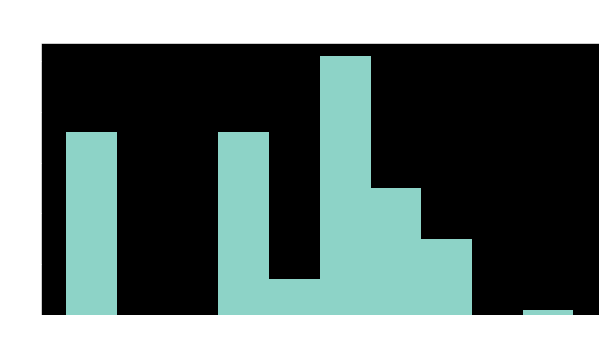

Number of articles with cos_sim > 0.3:  31


In [23]:
print('The total number of articles is: ', len(data_text))
plt.figure(figsize=(10, 5))
plt.hist(data_text['lda_similarity'])
plt.suptitle('Distribution of Cosine Similarity Values')
plt.title('Between Articles and Top 30 LDA Tokens')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

print('Number of articles with cos_sim > 0.3: ', len(
    data_text[data_text['lda_similarity'] > 0.3]))

The total number of articles is:  171


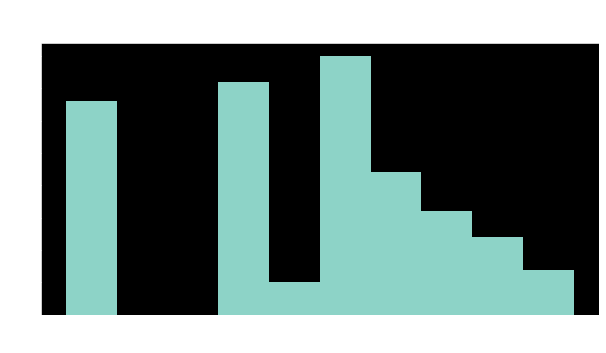

Number of articles with cos_sim > 0.3:  102


In [24]:
print('The total number of articles is: ', len(data_text))
plt.figure(figsize=(10, 5))
plt.hist(data_text['max_frequency_similarity'])
plt.suptitle('Distribution of Cosine Similarity Values')
plt.title('Between Articles and Top 30 Most Frequent Tokens')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

print('Number of articles with cos_sim > 0.3: ', len(
    data_text[data_text['max_frequency_similarity'] > 0.2]))

In [25]:
# LDA gives us:

# - A distribution over topics for each document
# - A distribution over words for each topics

In [26]:
# data_text['article_bow'] = data_text['processed_all_text'].swifter.apply(make_bow)

In [27]:
# for row_index, row in data_text_n_1[10:20].iterrows():
#     row = row.copy()
#     new_doc = [mcl_dictionary.doc2bow(row['processed_all_text'])]
# #     print(new_doc)
#     lda_result = gensim.models.ldamodel.LdaModel(corpus = new_doc,
#                                            id2word = mcl_dictionary,
#                                            num_topics = num_topics,
#                                            random_state = 100,
#                                            update_every = 1,
#                                            chunksize = 100,
#                                            passes = 10 ,
#                                            alpha = 'auto',
#                                            per_word_topics = True)


# #     x = lda_result.show_topics(num_words=30,formatted=False)

# #     doc_topics =[]
# #     for topics in x:
# #         for word, prob in topics[1]:
# #              doc_topics.append(word)

In [28]:
mcl_total_cluster_corpus = [' '.join(mcl_corpus)]

In [29]:
count_vectorizer = CountVectorizer()
mcl_total_cluster_count_mat = count_vectorizer.fit_transform(mcl_total_cluster_corpus)
mcl_doc_term_count_mat = count_vectorizer.transform(mcl_corpus)

prob_transformer = TfidfTransformer(norm='l1', use_idf=False, smooth_idf=False)

mcl_total_cluster_prob_mat = prob_transformer.fit_transform(mcl_total_cluster_count_mat)
mcl_doc_term_prob_mat = prob_transformer.fit_transform(mcl_doc_term_count_mat)

In [30]:
mcl_total_cluster_count_mat

<1x12039 sparse matrix of type '<class 'numpy.int64'>'
	with 12039 stored elements in Compressed Sparse Row format>

In [31]:
mcl_doc_term_count_mat

<171x12039 sparse matrix of type '<class 'numpy.int64'>'
	with 14007 stored elements in Compressed Sparse Row format>

In [32]:
mcl_total_cluster_prob_mat

<1x12039 sparse matrix of type '<class 'numpy.float64'>'
	with 12039 stored elements in Compressed Sparse Row format>

In [33]:
mcl_doc_term_prob_mat

<171x12039 sparse matrix of type '<class 'numpy.float64'>'
	with 14007 stored elements in Compressed Sparse Row format>

In [34]:
data_text['doc_term_prob'] = mcl_doc_term_prob_mat.toarray().tolist()

In [35]:
# distance.jensenshannon([1.0, 0.0, 0.0], [0.0, 1.0, 0.0])

In [36]:
mcl_total_cluster_prob_vec = mcl_total_cluster_prob_mat.toarray().tolist()[0]


def calculate_jsd(prob_array, cluster_prob_vec=mcl_total_cluster_prob_vec):

    jsd = distance.jensenshannon(prob_array, cluster_prob_vec)

    return jsd

In [37]:
data_text['JSD'] = data_text['doc_term_prob'].swifter.apply(calculate_jsd)

In [38]:
data_text.head()

,scp,title,abstract_text,processed_title,processed_abstract,processed_all_text,processed_all_text_frequencies,lda_similarity,max_frequency_similarity,doc_term_prob,JSD
0,14094190,THE HIPPOCAMPUS AND BEHAVIOR,THE LITERATURE ON THE BEHAVIORAL EFFECTS OF HI...,[hippocampus_behavior],"[literature_behavioral, behavioral_hippocampal...","[hippocampus_behavior, literature_behavioral, ...","{'hippocampus_behavior': 1, 'literature_behavi...",0.311086,0.297044,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.818141
1,15027475,Limbic-diencephalic mechanisms of voluntary mo...,Data from a series of brain-behavior experimen...,"[limbic-diencephalic_mechanism, mechanism_volu...","[series_brain-behavior, brain-behavior_experim...","[limbic-diencephalic_mechanism, mechanism_volu...","{'limbic-diencephalic_mechanism': 1, 'mechanis...",0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.822851
2,16308045,Recognition impaired and association intact in...,Three rhesus monkeys with transection of the f...,"[recognition_impair, impair_association, assoc...","[rhesus_transection, transection_fornix, forni...","[recognition_impair, impair_association, assoc...","{'recognition_impair': 1, 'impair_association'...",0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.821439
3,15699567,The hippocampus and behavioral maturation,The morphology and connections of the hippocam...,"[hippocampus_behavioral, behavioral_maturation]","[morphology_connection, connection_hippocampus...","[hippocampus_behavioral, behavioral_maturation...","{'hippocampus_behavioral': 1, 'behavioral_matu...",0.311086,0.297044,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.805395
4,16770743,Latent inhibition and stimulus generalization ...,30 male and female New Zealand albino rabbits ...,"[latent_inhibition, inhibition_stimulus, stimu...","[male_female, female_zealand, zealand_albino, ...","[latent_inhibition, inhibition_stimulus, stimu...","{'latent_inhibition': 2, 'inhibition_stimulus'...",0.254000,0.285831,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.816257


In [39]:
data_text.describe()

,lda_similarity,max_frequency_similarity,JSD
count,171.000000,171.000000,171.000000
mean,0.200687,0.213720,0.815465
std,0.116301,0.126701,0.006389
min,0.000000,0.000000,0.790574
25%,0.179605,0.171499,0.811056
50%,0.240966,0.230089,0.816257
75%,0.281788,0.297044,0.820162
max,0.475191,0.460179,0.829449


The total number of articles is:  171


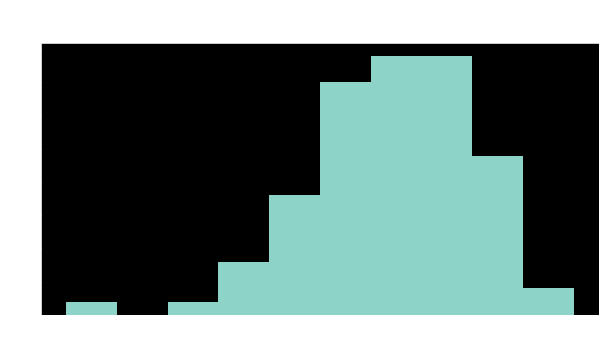

In [40]:
print('The total number of articles is: ', len(data_text))
plt.figure(figsize=(10, 5))
plt.hist(data_text['JSD'])
plt.suptitle('Distribution of JSD Values')
# plt.title('Between Articles and Top 30 Most Frequent Tokens')
plt.xlabel('JSD')
plt.ylabel('Frequency')
plt.show()

# print('Number of articles with cos_sim > 0.3: ', len(data_text[data_text['max_frequency_similarity']>0.2]))